# Update the Global warming projections using observations, following the [reference paper by Ribes, Qasmi, Gillet](https://doi.org/10.1126/sciadv.abc0671).

## This notebook aims to update the Global Mean Surface Temperature (GMST) constraint. It requires the Kriging for Climate Change (KCC) package (available at: https://gitlab.com/saidqasmi/KCC).

In [1]:
library(KCC)
library(abind)
# Set random number generator to ensure reproducibility
set.seed(13)

In [2]:
# Set a reference period for observations
ref_obs=1961:1990

# Parameter nb resampling
Nres = 1000
sample_str = c("be",paste0("nres",1:Nres))

### Load the response to the external forcings (natural+anthropogenic) for all available CMIP6 models for the historical period and the three scenarios (SSP1-2.6, SSP2-4.5, SSP5-8.5).

In [3]:
load("./data/X_fit_GSAT_CMIP6.Rdata")
year = as.numeric(dimnames(X_fit_26)$year)
ny = length(year)

Models_26 = dimnames(X_fit_26)$model
Models_45 = dimnames(X_fit_45)$model
Models_85 = dimnames(X_fit_85)$model
Nmod_26 = length(Models_26)
Nmod_45 = length(Models_45)
Nmod_85 = length(Models_85)

X_26_fit_anom_tmp = apply(X_fit_26[year %in% ref_obs,,], c(2,3), mean, na.rm=T)
X_26_fit = sweep(X_fit_26, STATS=X_26_fit_anom_tmp, MARGIN=c(2,3))
X_45_fit_anom_tmp = apply(X_fit_45[year %in% ref_obs,,], c(2,3), mean, na.rm=T)
X_45_fit = sweep(X_fit_45, STATS=X_45_fit_anom_tmp, MARGIN=c(2,3))
X_85_fit_anom_tmp = apply(X_fit_85[year %in% ref_obs,,], c(2,3), mean, na.rm=T)
X_85_fit = sweep(X_fit_85, STATS=X_85_fit_anom_tmp, MARGIN=c(2,3))


### Download the HadCRUT5 GMST observations directly from the Hadley Center server.

In [4]:
Xo_raw = as.matrix(read.table(file="https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.ensemble_series.global.annual.csv",header=T, sep=","))[,-c(1,2,3)]
nmb = dim(Xo_raw)[2]

# Extract data up to 2021
year_obs = 1850:2021
ny_obs = length(year_obs)
Xog = array(data = cbind(Xo_raw[1:ny_obs,],apply(Xo_raw[1:ny_obs,],1,median)),
            dim = c(ny_obs,nmb+1),
            dimnames = list(year = year_obs,
                            member = c(as.character(1:nmb),"median"))
           )

### We compute the new observational uncertainty

In [5]:
#  Calculate obs residuals
Xg_mmm  = apply(X_45_fit[,"all",],1,mean,na.rm=T)
Xgc_mmm = Xg_mmm - mean(Xg_mmm[year %in% ref_obs])
Xogc    = Xog[as.character(year_obs),"median"] - mean(Xog[year_obs %in% ref_obs,"median"])
Xog_res = Xogc - Xgc_mmm[as.character(year_obs)]
# Fit the parameters of the MAR models on residuals
message("Estimate uncertainty for internal variability (may take some time!)...")
theta_obs = estim_mar2_link(Xog_res)
# Compute the associated covariance matrix
Sigma_obs_iv = Sigma_mar2(theta_obs,ny_obs)
# Add the measurement uncertainty contribution
Sigma_obs = Sigma_obs_iv + var(t(Xog[as.character(year_obs),-201]))


Estimate uncertainty for internal variability (may take some time!)...



initial  value -624.223969 
iter   2 value -627.449261
iter   3 value -628.244722
iter   4 value -628.509065
iter   5 value -628.687491
iter   6 value -629.809645
iter   7 value -629.853958
iter   8 value -629.857220
iter   9 value -629.858411
iter  10 value -629.858540
iter  10 value -629.858543
final  value -629.858543 
converged


### Compute the constrained projections...

In [6]:
X_krig_26_list = prior2posterior(X_26_fit, Xog, Sigma_obs, Nres, centering_CX=T, ref_CX=1850:1900)
X_krig_45_list = prior2posterior(X_45_fit, Xog, Sigma_obs, Nres, centering_CX=T, ref_CX=1850:1900)
X_krig_85_list = prior2posterior(X_85_fit, Xog, Sigma_obs, Nres, centering_CX=T, ref_CX=1850:1900)

In [7]:
# X_unconstrained
X_uncons_26 = mvgauss_to_Xarray(X_krig_26_list$uncons$mean,X_krig_26_list$uncons$var,Nres)
X_uncons_45 = mvgauss_to_Xarray(X_krig_45_list$uncons$mean,X_krig_45_list$uncons$var,Nres)
X_uncons_85 = mvgauss_to_Xarray(X_krig_85_list$uncons$mean,X_krig_85_list$uncons$var,Nres)
# X_constrained
X_cons_26 = mvgauss_to_Xarray(X_krig_26_list$cons$mean,X_krig_26_list$cons$var,Nres)
X_cons_45 = mvgauss_to_Xarray(X_krig_45_list$cons$mean,X_krig_45_list$cons$var,Nres)
X_cons_85 = mvgauss_to_Xarray(X_krig_85_list$cons$mean,X_krig_85_list$cons$var,Nres)
# Put X_uncons and X_cons together
l_tmp = c(dimnames(X_uncons_26)[1:3], list(constrain=c("uncons","cons")))
X_krig_26 = abind(X_uncons_26, X_cons_26, along=4)
X_krig_45 = abind(X_uncons_45, X_cons_45, along=4)
X_krig_85 = abind(X_uncons_85, X_cons_85, along=4)
dimnames(X_krig_26) = l_tmp
dimnames(X_krig_45) = l_tmp
dimnames(X_krig_85) = l_tmp

### ... and plot them !

Retrieve the results from Ribes et al. 2020



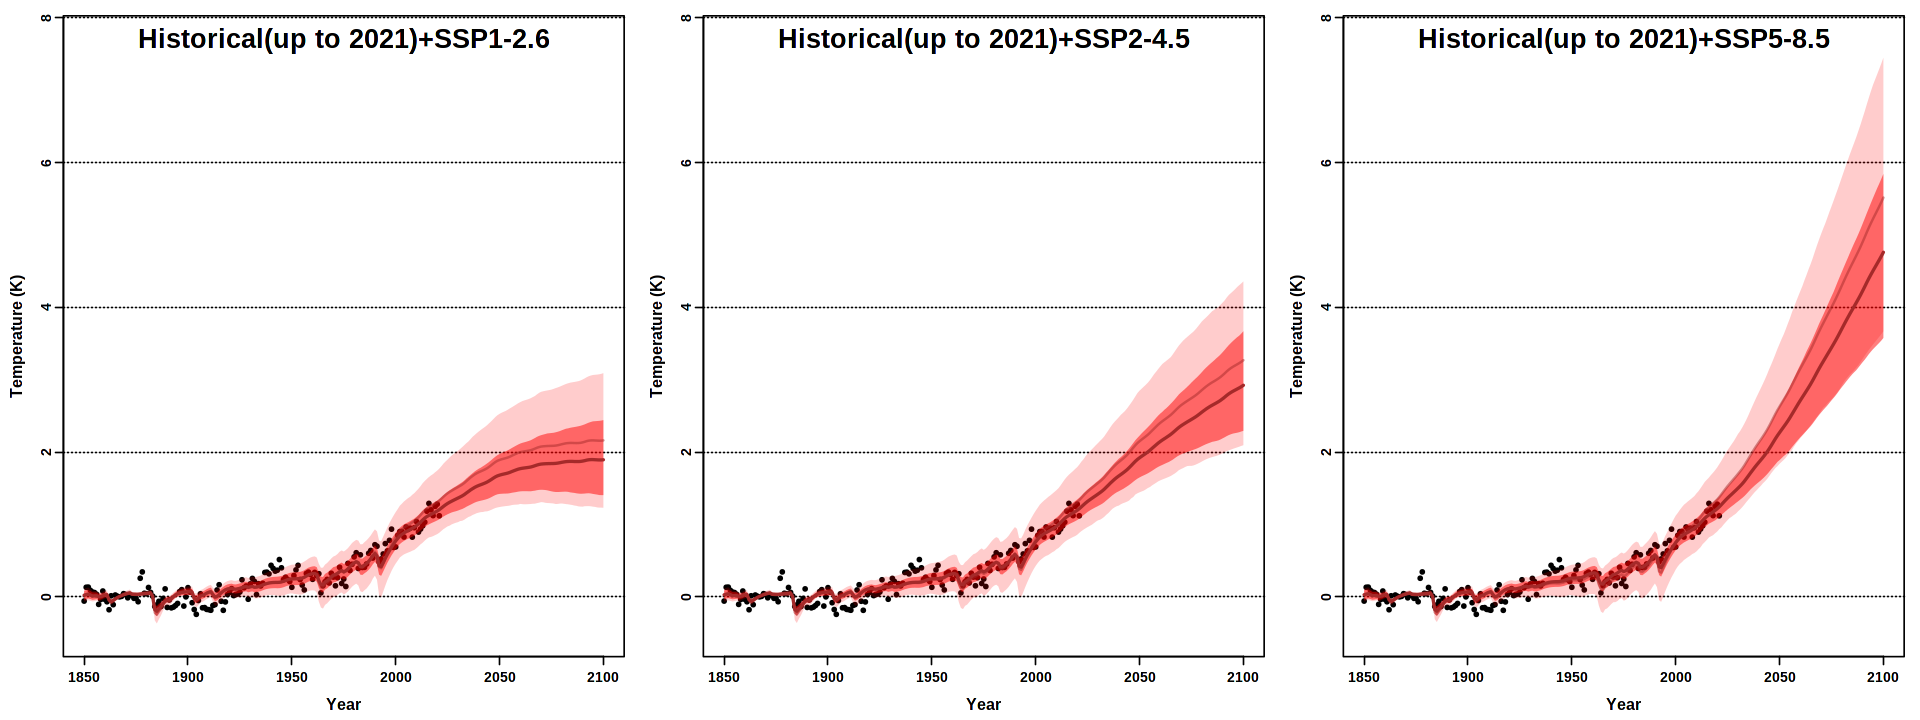

In [8]:
set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

source("routines/plot_cons.R")
ylim = c(-.5,7.7)
ref_plot = 1850:1900
message("Retrieve the results from Ribes et al. 2020")
set_plot_dimensions(16, 6)
par(mfrow=c(1,3))
plot_cons(X_krig_26, Xog, ref_plot=ref_plot, ny=ny, ylim=ylim, title="Historical(up to 2021)+SSP1-2.6")
plot_cons(X_krig_45, Xog, ref_plot=ref_plot, ny=ny, ylim=ylim, title="Historical(up to 2021)+SSP2-4.5")
plot_cons(X_krig_85, Xog, ref_plot=ref_plot, ny=ny, ylim=ylim, title="Historical(up to 2021)+SSP5-8.5")

### Quantification of the observed and projected warming

In [9]:
write_ci = function(v) {
        message("   ",round(v["be"],2),", CI[",round(quantile(v[-1],.05),2),", ",round(quantile(v[-1],.95),2),"]")
}


# Calculation
year_clim = 2012:2021
year_mid = 2041:2060
year_proj = 2081:2100

Delta_obs = apply(X_krig_45[as.character(year_clim),,"all","cons"],2,mean) - apply(X_krig_45[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_obs_today = X_krig_45["2021",,"all","cons"] - apply(X_krig_45[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_proj_26 = apply(X_krig_26[as.character(year_proj),,"all","cons"],2,mean) - apply(X_krig_26[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_proj_45 = apply(X_krig_45[as.character(year_proj),,"all","cons"],2,mean) - apply(X_krig_45[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_proj_85 = apply(X_krig_85[as.character(year_proj),,"all","cons"],2,mean) - apply(X_krig_85[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_2050_26 = X_krig_26["2050",,"all","cons"] - apply(X_krig_26[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_2050_45 = X_krig_45["2050",,"all","cons"] - apply(X_krig_45[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_2050_85 = X_krig_85["2050",,"all","cons"] - apply(X_krig_85[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_2100_26 = X_krig_26["2100",,"all","cons"] - apply(X_krig_26[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_2100_45 = X_krig_45["2100",,"all","cons"] - apply(X_krig_45[year %in% 1850:1900,,"all","cons"],2,mean)
Delta_2100_85 = X_krig_85["2100",,"all","cons"] - apply(X_krig_85[year %in% 1850:1900,,"all","cons"],2,mean)

message("Total forced warming over the 2012–2021 decade relative to the 1850–1900 preindustrial baseline")
write_ci(Delta_obs)
message("Total forced warming in 2021")
write_ci(Delta_obs_today)
message("-----------------")
message("Total forced warming in 2050 for SSP126")
write_ci(Delta_2050_26)
message("Total forced warming in 2050 for SSP245")
write_ci(Delta_2050_45)
message("Total forced warming in 2050 for SSP585")
write_ci(Delta_2050_85)
message("-----------------")
message("Total forced warming over the 2081-2100 period for SSP126")
write_ci(Delta_proj_26)
message("Total forced warming over the 2081-2100 period for SSP245")
write_ci(Delta_proj_45)
message("Total forced warming over the 2081-2100 period for SSP585")
write_ci(Delta_proj_85)
message("-----------------")
message("Total forced warming in 2100 for SSP126")
write_ci(Delta_2100_26)
message("Total forced warming in 2100 for SSP245")
write_ci(Delta_2100_45)
message("Total forced warming in 2100 for SSP585")
write_ci(Delta_2100_85)


Total forced warming over the 2012–2021 decade relative to the 1850–1900 preindustrial baseline

   1.13, CI[1, 1.26]

Total forced warming in 2021

   1.22, CI[1.08, 1.37]

-----------------

Total forced warming in 2050 for SSP126

   1.68, CI[1.42, 1.97]

Total forced warming in 2050 for SSP245

   1.92, CI[1.65, 2.23]

Total forced warming in 2050 for SSP585

   2.27, CI[1.89, 2.64]

-----------------

Total forced warming over the 2081-2100 period for SSP126

   1.88, CI[1.43, 2.38]

Total forced warming over the 2081-2100 period for SSP245

   2.75, CI[2.2, 3.4]

Total forced warming over the 2081-2100 period for SSP585

   4.26, CI[3.26, 5.19]

-----------------

Total forced warming in 2100 for SSP126

   1.89, CI[1.4, 2.44]

Total forced warming in 2100 for SSP245

   2.92, CI[2.29, 3.67]

Total forced warming in 2100 for SSP585

   4.76, CI[3.58, 5.84]

